In [53]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [54]:
# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures


In [55]:
# Statistical Analysis
from scipy import stats

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [56]:
# Configure plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create output directories
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)


In [57]:
#### Model configuration

In [58]:

CONFIG = {
    'test_size': 0.2,
    'random_state': 42,
    'cv_folds': 5,
    'poly_degree': 2
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")


Configuration:
  test_size: 0.2
  random_state: 42
  cv_folds: 5
  poly_degree: 2


In [59]:
### Load Dataset

In [60]:
data = pd.read_csv('../data/stars.csv')

print(f" Data loaded successfully!")
print(f" Dataset shape: {data.shape}")
print(f" Columns: {list(data.columns)}")

# Display first few rows
data.head()

 Data loaded successfully!
 Dataset shape: (240, 7)
 Columns: ['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type', 'Star color', 'Spectral Class']


,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3042,0.0005,0.1542,16.6,0.0,Red,M
2,2600,0.0003,0.102,18.7,0.0,Red,M
3,2800,0.0002,,16.65,0.0,Red,M
4,1939,0.000138,0.103,20.06,0.0,Red,M


In [61]:
### Initial Data Inspection

In [62]:
# Check data types and missing values
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print("\n*** Data Info: ***")
data.info()

print("\n*** Statistical Summary: ***")
data.describe()

print("\n*** Missing Values: ***")
print(data.isnull().sum())

DATA OVERVIEW

*** Data Info: ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature(K)          239 non-null    object 
 1   Luminosity(L/Lo)        239 non-null    object 
 2   Radius(R/Ro)            239 non-null    object 
 3   Absolute magnitude(Mv)  239 non-null    object 
 4   Star type               239 non-null    float64
 5   Star color              239 non-null    object 
 6   Spectral Class          239 non-null    object 
dtypes: float64(1), object(6)
memory usage: 13.3+ KB

*** Statistical Summary: ***

*** Missing Values: ***
Temperature(K)            1
Luminosity(L/Lo)          1
Radius(R/Ro)              1
Absolute magnitude(Mv)    1
Star type                 1
Star color                1
Spectral Class            1
dtype: int64


In [63]:
### Data Cleaning

In [64]:
# Strip spaces from column names
data.columns = data.columns.str.strip()

# Replace empty strings and whitespace-only cells with NaN
data = data.replace(r'^\s*$', pd.NA, regex=True)

# Convert numeric columns to proper numbers
numeric_cols = ['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

print(f"\n*** Missing values after type conversion: ***")
print(data[numeric_cols].isnull().sum())



*** Missing values after type conversion: ***
Temperature(K)            3
Luminosity(L/Lo)          7
Radius(R/Ro)              8
Absolute magnitude(Mv)    6
dtype: int64


In [65]:
### Filling Missing Values

In [66]:
# For Luminosity and Radius: use median per Star type
for col in ['Luminosity(L/Lo)', 'Radius(R/Ro)']:
    data[col] = data.groupby('Star type')[col].transform(lambda x: x.fillna(x.median()))

# For Temperature: use overall median
data['Temperature(K)'] = data['Temperature(K)'].fillna(data['Temperature(K)'].median())

# For Absolute magnitude: use median per Star type
data['Absolute magnitude(Mv)'] = data.groupby('Star type')['Absolute magnitude(Mv)'].transform(
    lambda x: x.fillna(x.median())
)

# Drop rows where critical columns are still missing
initial_rows = len(data)
data = data.dropna(subset=['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)'])
dropped_rows = initial_rows - len(data)

# Fill missing categorical values
data['Spectral Class'] = data['Spectral Class'].fillna('Unknown')
data['Star color'] = data['Star color'].fillna('Unknown')

In [67]:
print(f"\n--- Data Cleaning Complete! ---")
print(f"Rows dropped: {dropped_rows}")
print(f"Final dataset shape: {data.shape}")
print(f"\nNo remaining missing values in critical columns:")
print(data[numeric_cols].isnull().sum())


--- Data Cleaning Complete! ---
Rows dropped: 1
Final dataset shape: (239, 7)

No remaining missing values in critical columns:
Temperature(K)            0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
dtype: int64


In [68]:
###Cleaned Dataset Summery

In [69]:
print("="*100)
print("CLEANED DATA SUMMARY")
print("="*100)

print("\n ---Star Type Distribution:---")
print(data['Star type'].value_counts().sort_index())

print("\n ---Spectral Class Distribution:---")
print(data['Spectral Class'].value_counts())

print("\n ---Numerical Features Summary:---")
data[numeric_cols].describe()

CLEANED DATA SUMMARY

 ---Star Type Distribution:---
Star type
0.0    39
1.0    40
2.0    40
3.0    40
4.0    40
5.0    40
Name: count, dtype: int64

 ---Spectral Class Distribution:---
Spectral Class
M          109
B           46
O           39
A           19
F           17
K            6
Unknown      2
G            1
Name: count, dtype: int64

 ---Numerical Features Summary:---


,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,239.000000,239.000000,239.000000,239.000000
mean,10474.029289,106578.271084,237.420968,4.298598
std,9535.231482,178338.537758,516.322417,10.546375
min,1939.000000,0.000080,0.008400,-11.920000
25%,3355.000000,0.000834,0.102000,-6.235000
50%,5800.000000,0.085000,0.795000,6.506000
75%,14857.000000,198100.000000,43.500000,13.668500
max,40000.000000,849420.000000,1948.500000,20.060000


In [70]:
### Exploratory Data Analyisis (EDA)

In [71]:
### EDA - Star Type Distribution

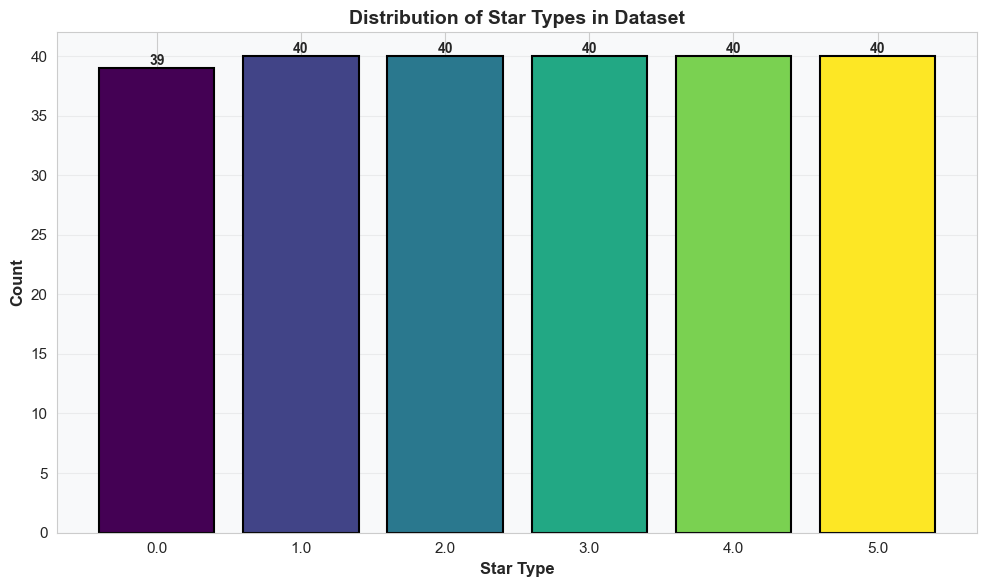

 Plot saved: plots/star_type_distribution.png

Star Type Counts:
   Type 0.0: 39 stars
   Type 1.0: 40 stars
   Type 2.0: 40 stars
   Type 3.0: 40 stars
   Type 4.0: 40 stars
   Type 5.0: 40 stars


In [72]:

fig, ax = plt.subplots(figsize=(10, 6))

# Get star type counts and sort by index
star_counts = data['Star type'].value_counts().sort_index()

# Convert index to strings for proper categorical plotting
star_types = [str(x) for x in star_counts.index]
counts = star_counts.values

# Create color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(star_types)))

# Create bar plot
bars = ax.bar(star_types, counts, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Star Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Star Types in Dataset', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add background color
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('plots/star_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/star_type_distribution.png")
print(f"\nStar Type Counts:")
for star_type, count in zip(star_types, counts):
    print(f"   Type {star_type}: {count} stars")

In [73]:
### EDA -  Hertzsprung-Russel Diagram

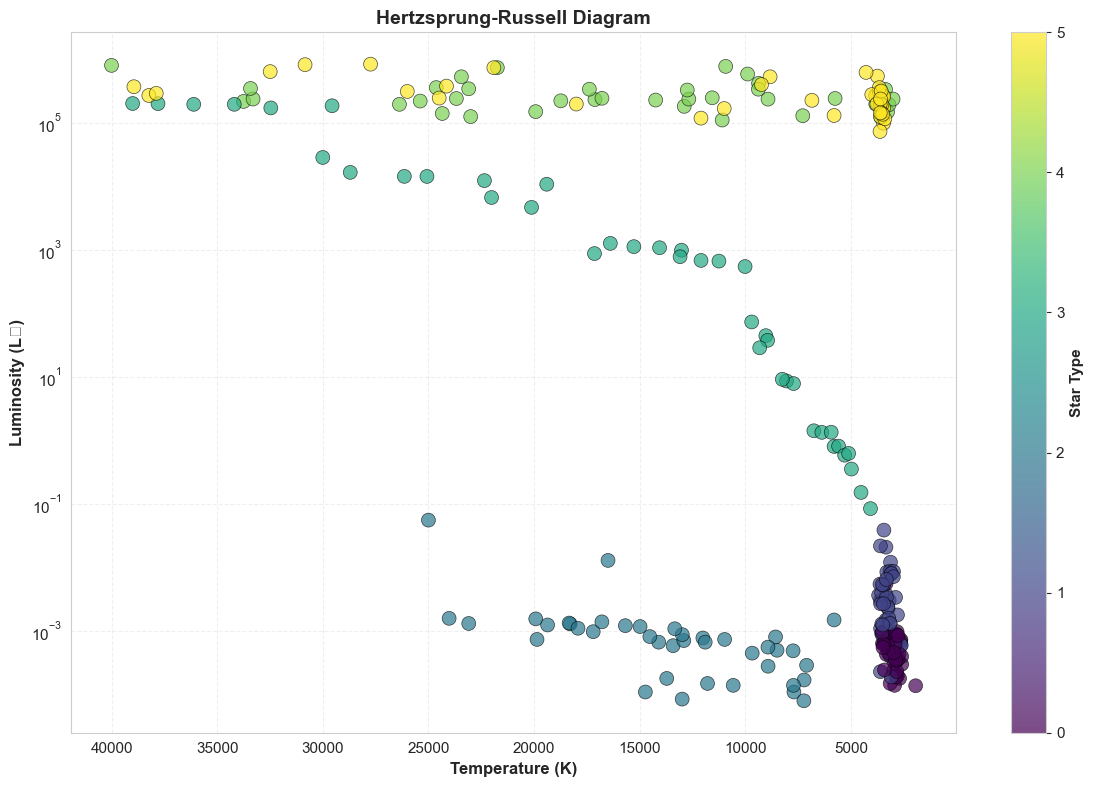

 Plot saved: plots/hr_diagram.png

*** The H-R Diagram shows the relationship between star temperature and luminosity ***
   - Main sequence stars form a diagonal band
   - Giants and supergiants appear in the upper right
   - White dwarfs appear in the lower left


In [74]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(data['Temperature(K)'], 
                     data['Luminosity(L/Lo)'],
                     c=data['Star type'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=100,
                     edgecolor='black',
                     linewidth=0.5)

ax.set_yscale('log')
ax.invert_xaxis()  # HR diagram convention: hot stars on left

ax.set_xlabel('Temperature (K)', fontsize=12, fontweight='bold')
ax.set_ylabel('Luminosity (L☉)', fontsize=12, fontweight='bold')
ax.set_title('Hertzsprung-Russell Diagram', fontsize=14, fontweight='bold')

cbar = plt.colorbar(scatter, label='Star Type')
cbar.set_label('Star Type', fontsize=11, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('plots/hr_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/hr_diagram.png")
print("\n*** The H-R Diagram shows the relationship between star temperature and luminosity ***")
print("   - Main sequence stars form a diagonal band")
print("   - Giants and supergiants appear in the upper right")
print("   - White dwarfs appear in the lower left")

In [75]:
### EDA - Luminosity VS Radious

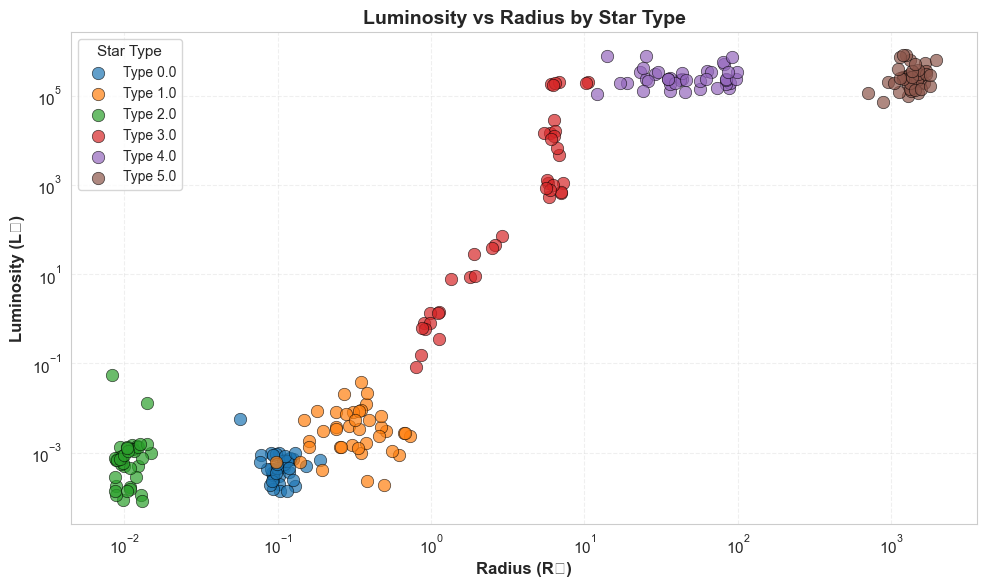

 Plot saved: plots/luminosity_vs_radius.png


In [76]:
fig, ax = plt.subplots(figsize=(10, 6))

for star_type in sorted(data['Star type'].unique()):
    subset = data[data['Star type'] == star_type]
    ax.scatter(subset['Radius(R/Ro)'], 
               subset['Luminosity(L/Lo)'],
               label=f'Type {star_type}',
               alpha=0.7,
               s=80,
               edgecolor='black',
               linewidth=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Radius (R☉)', fontsize=12, fontweight='bold')
ax.set_ylabel('Luminosity (L☉)', fontsize=12, fontweight='bold')
ax.set_title('Luminosity vs Radius by Star Type', fontsize=14, fontweight='bold')
ax.legend(title='Star Type', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('plots/luminosity_vs_radius.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/luminosity_vs_radius.png")


In [77]:
### EDA - Correlation Heatmap

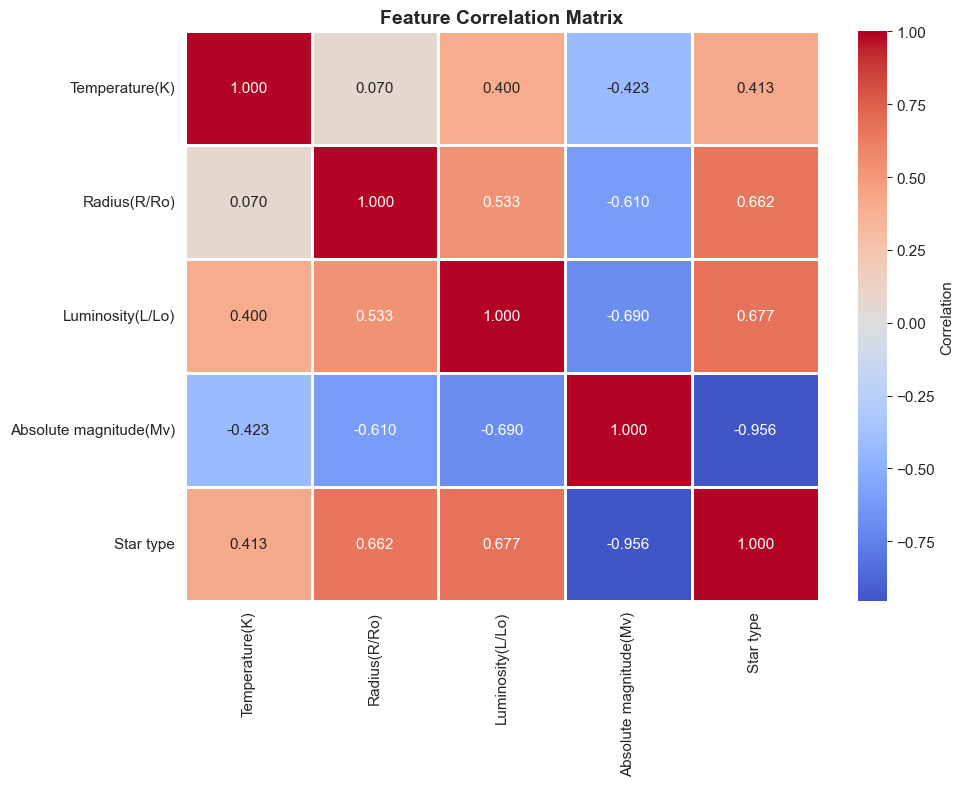

 Plot saved: plots/correlation_heatmap.png

 Key Correlations:
Luminosity(L/Lo)          1.000000
Star type                 0.676591
Radius(R/Ro)              0.533220
Temperature(K)            0.399992
Absolute magnitude(Mv)   -0.689981
Name: Luminosity(L/Lo), dtype: float64


In [78]:
# Correlation analysis
correlation_data = data[['Temperature(K)', 'Radius(R/Ro)', 'Luminosity(L/Lo)', 
                         'Absolute magnitude(Mv)', 'Star type']].copy()

fig, ax = plt.subplots(figsize=(10, 8))
correlation_matrix = correlation_data.corr()

sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f',
            linewidths=1,
            cbar_kws={'label': 'Correlation'},
            ax=ax)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/correlation_heatmap.png")
print("\n Key Correlations:")
print(correlation_matrix['Luminosity(L/Lo)'].sort_values(ascending=False))


In [79]:
### EDA - Pairplot

 Creating pairplot (this may take a moment)...


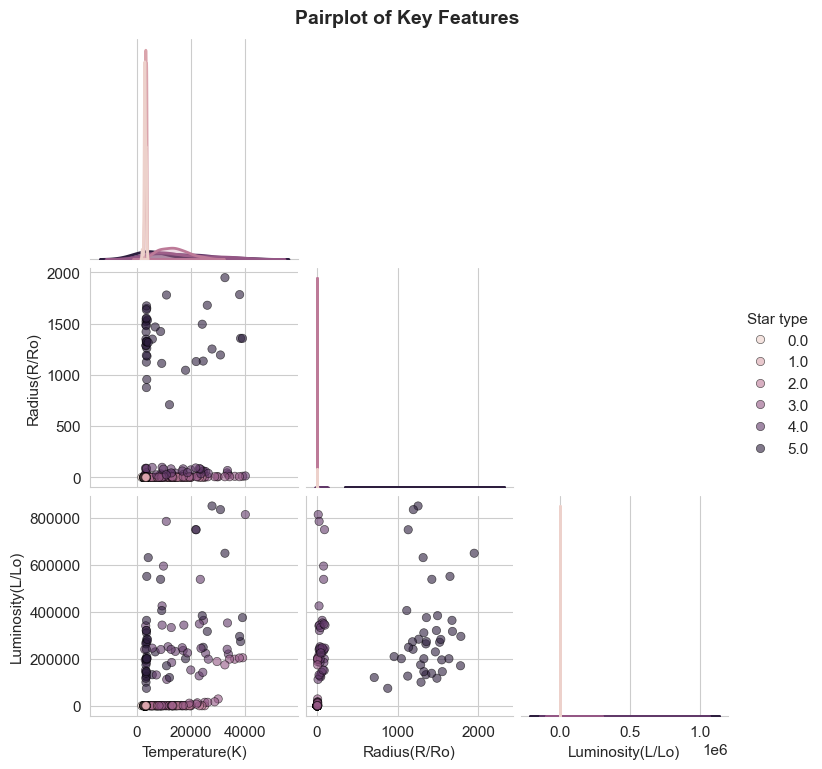

 Plot saved: plots/pairplot.png


In [80]:
print(" Creating pairplot (this may take a moment)...")

pairplot = sns.pairplot(data[['Temperature(K)', 'Radius(R/Ro)', 'Luminosity(L/Lo)', 'Star type']], 
                        hue='Star type',
                        corner=True,
                        diag_kind='kde',
                        plot_kws={'alpha': 0.6, 'edgecolor': 'black', 'linewidth': 0.5},
                        diag_kws={'linewidth': 2})

pairplot.fig.suptitle('Pairplot of Key Features', y=1.02, fontsize=14, fontweight='bold')
plt.savefig('plots/pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/pairplot.png")

In [81]:
### Feature Engineering


 Created log_Luminosity feature
   Original Luminosity range: [0.000080, 849420.00]
   Log Luminosity range: [-4.10, 5.93]


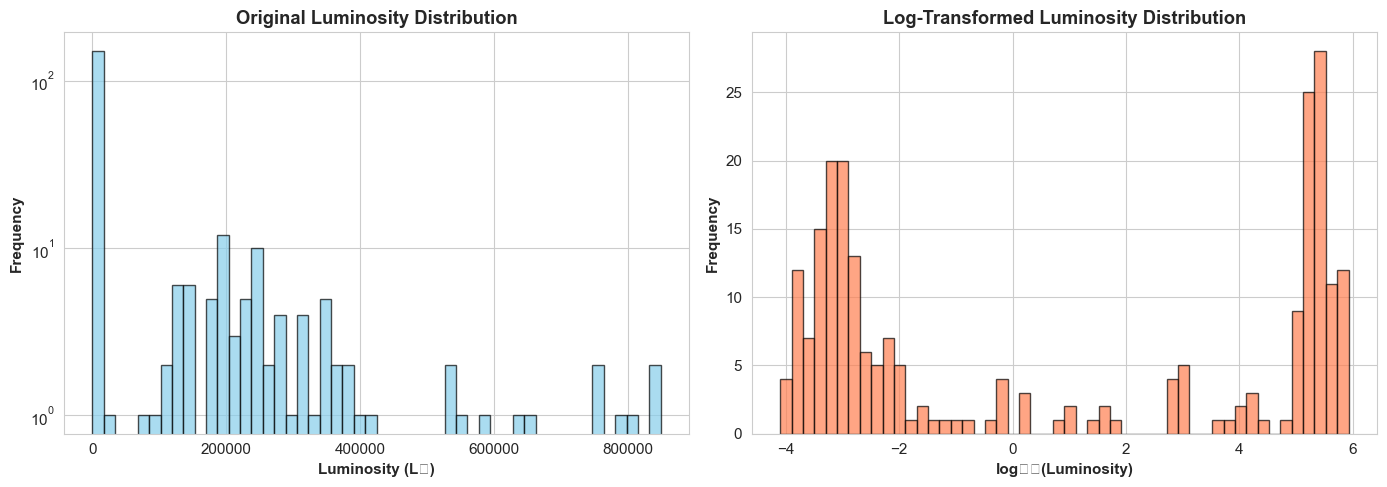

 Plot saved: plots/luminosity_transformation.png


In [82]:
# Log-transform the target variable (Luminosity)
# Because: Luminosity spans many orders of magnitude (0.0001 to 800,000+)
data['log_Luminosity'] = np.log10(data['Luminosity(L/Lo)'])

print("\n Created log_Luminosity feature")
print(f"   Original Luminosity range: [{data['Luminosity(L/Lo)'].min():.6f}, {data['Luminosity(L/Lo)'].max():.2f}]")
print(f"   Log Luminosity range: [{data['log_Luminosity'].min():.2f}, {data['log_Luminosity'].max():.2f}]")

# Visualize the transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(data['Luminosity(L/Lo)'], bins=50, edgecolor='black', color='skyblue', alpha=0.7)
axes[0].set_xlabel('Luminosity (L☉)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Original Luminosity Distribution', fontweight='bold')
axes[0].set_yscale('log')

# Log-transformed distribution
axes[1].hist(data['log_Luminosity'], bins=50, edgecolor='black', color='coral', alpha=0.7)
axes[1].set_xlabel('log₁₀(Luminosity)', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Log-Transformed Luminosity Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/luminosity_transformation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/luminosity_transformation.png")


In [83]:
### Prepare Features and Target

In [84]:
# Select features for modeling
feature_cols = ['Temperature(K)', 'Radius(R/Ro)', 'Star type', 'Spectral Class']
X_raw = data[feature_cols].copy()
y = data['log_Luminosity'].copy()

print(f"\n Feature Matrix Shape: {X_raw.shape}")
print(f" Target Vector Shape: {y.shape}")
print(f"\n Features being used:")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i}. {col}")



 Feature Matrix Shape: (239, 4)
 Target Vector Shape: (239,)

 Features being used:
   1. Temperature(K)
   2. Radius(R/Ro)
   3. Star type
   4. Spectral Class


In [85]:
### Slpt Tranning Data and Testing Data

In [86]:

# Use stratify to maintain star type distribution
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, 
    y, 
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=X_raw['Star type']  # Ensure balanced split across star types
)

print(f"\n Data split complete!")
print(f" Training set size: {len(X_train_raw)} samples ({(1-CONFIG['test_size'])*100:.0f}%)")
print(f" Test set size: {len(X_test_raw)} samples ({CONFIG['test_size']*100:.0f}%)")

print(f"\n Star type distribution in splits:")
print("\nTraining set:")
print(X_train_raw['Star type'].value_counts().sort_index())
print("\nTest set:")
print(X_test_raw['Star type'].value_counts().sort_index())


 Data split complete!
 Training set size: 191 samples (80%)
 Test set size: 48 samples (20%)

 Star type distribution in splits:

Training set:
Star type
0.0    31
1.0    32
2.0    32
3.0    32
4.0    32
5.0    32
Name: count, dtype: int64

Test set:
Star type
0.0    8
1.0    8
2.0    8
3.0    8
4.0    8
5.0    8
Name: count, dtype: int64


In [87]:
### Processing PipeLine

In [88]:
# Define column types
numeric_features = ['Temperature(K)', 'Radius(R/Ro)']
categorical_features = ['Spectral Class']
passthrough_features = ['Star type']

print(f"\n Numeric features (will be scaled): {numeric_features}")
print(f" Categorical features (will be one-hot encoded): {categorical_features}")
print(f" Passthrough features (no transformation): {passthrough_features}")

# Create preprocessing pipeline
# ***This will be FIT on training data only!***
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 
         categorical_features),
        ('pass', 'passthrough', passthrough_features)
    ],
    remainder='drop'
)

# Fit on TRAINING data only and transform both sets
print("\n Fitting preprocessor on training data...")
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

print(f" Preprocessing complete!")
print(f" Transformed training features shape: {X_train.shape}")
print(f" Transformed test features shape: {X_test.shape}")
print(f" Number of features after encoding: {X_train.shape[1]}")

# Get feature names after preprocessing
feature_names_out = []
feature_names_out.extend(numeric_features)
feature_names_out.extend(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_names_out.extend(passthrough_features)

print(f"\n Final features: {feature_names_out}")


 Numeric features (will be scaled): ['Temperature(K)', 'Radius(R/Ro)']
 Categorical features (will be one-hot encoded): ['Spectral Class']
 Passthrough features (no transformation): ['Star type']

 Fitting preprocessor on training data...
 Preprocessing complete!
 Transformed training features shape: (191, 10)
 Transformed test features shape: (48, 10)
 Number of features after encoding: 10

 Final features: ['Temperature(K)', 'Radius(R/Ro)', 'Spectral Class_B', 'Spectral Class_F', 'Spectral Class_G', 'Spectral Class_K', 'Spectral Class_M', 'Spectral Class_O', 'Spectral Class_Unknown', 'Star type']


In [89]:
### Linear Regression Model

In [90]:
# Train the model
lr = LinearRegression()
print("\n Training Linear Regression model...")
lr.fit(X_train, y_train)
print(" Model trained!")

# Make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

# Cross-validation
print("\n Performing 5-fold cross-validation...")
cv_scores = cross_val_score(lr, X_train, y_train, cv=CONFIG['cv_folds'], scoring='r2')

# Display results
print("\n" + "="*100)
print("LINEAR REGRESSION RESULTS")
print("="*100)
print(f"\n1) Training Performance:")
print(f"   R² Score: {train_r2:.6f}")
print(f"   RMSE:     {train_rmse:.6f}")

print(f"\n2) Test Performance:")
print(f"   R² Score: {test_r2:.6f}")
print(f"   RMSE:     {test_rmse:.6f}")
print(f"   MAE:      {test_mae:.6f}")

print(f"\n3) Cross-Validation (5-fold):")
print(f"   CV R² Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"   Mean CV R²:   {cv_scores.mean():.6f} (± {cv_scores.std():.6f})")

# Check for overfitting
if train_r2 - test_r2 > 0.1:
    print(f"\n WARNING: Possible overfitting detected!")
    print(f"   Training R² ({train_r2:.4f}) significantly higher than Test R² ({test_r2:.4f})")
else:
    print(f"\n Model generalizes well (no significant overfitting)")

print("="*100)



 Training Linear Regression model...
 Model trained!

 Performing 5-fold cross-validation...

LINEAR REGRESSION RESULTS

1) Training Performance:
   R² Score: 0.916679
   RMSE:     1.137931

2) Test Performance:
   R² Score: 0.875437
   RMSE:     1.417835
   MAE:      1.169474

3) Cross-Validation (5-fold):
   CV R² Scores: ['0.9041', '0.8733', '0.8711', '0.9183', '0.8893']
   Mean CV R²:   0.891214 (± 0.018055)

 Model generalizes well (no significant overfitting)


In [91]:
### Model Co-efficient Analysis


 Feature Importance (by coefficient magnitude):
               Feature  Coefficient  Abs_Coefficient
      Spectral Class_M     2.459142         2.459142
             Star type     2.427006         2.427006
      Spectral Class_G     1.957730         1.957730
      Spectral Class_F    -1.613588         1.613588
      Spectral Class_K    -1.341462         1.341462
      Spectral Class_O     1.241779         1.241779
        Temperature(K)     0.825938         0.825938
          Radius(R/Ro)    -0.802747         0.802747
      Spectral Class_B    -0.553073         0.553073
Spectral Class_Unknown     0.177801         0.177801


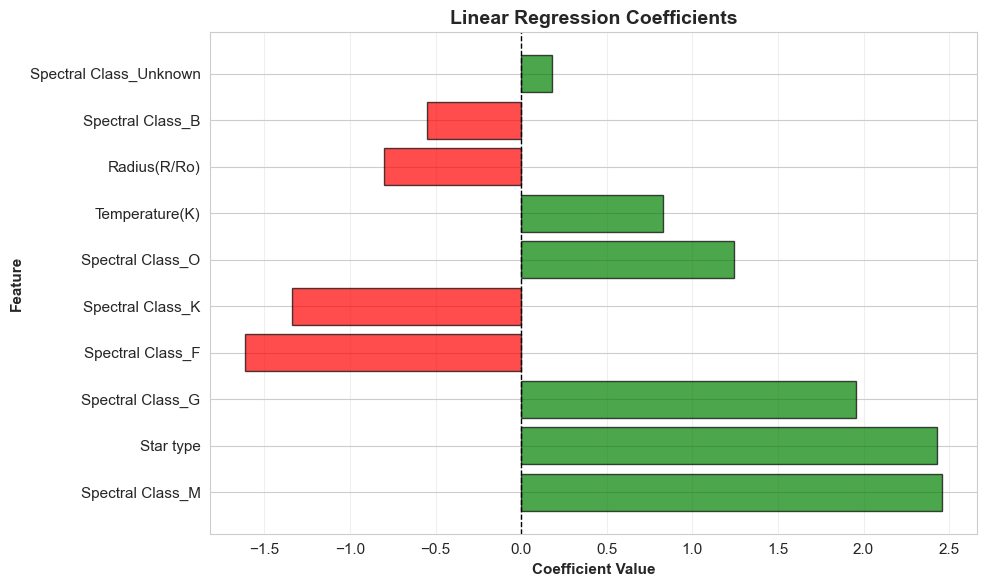


 Plot saved: plots/feature_coefficients.png


In [92]:
# Analyze feature importance
coefficients = pd.DataFrame({
    'Feature': feature_names_out,
    'Coefficient': lr.coef_
})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("\n Feature Importance (by coefficient magnitude):")
print(coefficients.to_string(index=False))

# Visualize coefficients
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in coefficients['Coefficient']]
bars = ax.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('Coefficient Value', fontweight='bold')
ax.set_ylabel('Feature', fontweight='bold')
ax.set_title('Linear Regression Coefficients', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Plot saved: plots/feature_coefficients.png")

In [93]:
### Polynomial Regression

In [94]:
# Create polynomial features
print(f"\n Creating polynomial features (degree={CONFIG['poly_degree']})...")
poly = PolynomialFeatures(degree=CONFIG['poly_degree'], include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f" Polynomial features created!")
print(f" Original features: {X_train.shape[1]}")
print(f" Polynomial features: {X_train_poly.shape[1]}")
print(f" Features added: {X_train_poly.shape[1] - X_train.shape[1]}")

# Train polynomial model
print("\n Training Polynomial Regression model...")
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
print(" Model trained!")

# Make predictions
y_test_poly_pred = lr_poly.predict(X_test_poly)
y_train_poly_pred = lr_poly.predict(X_train_poly)

# Calculate metrics
train_poly_r2 = r2_score(y_train, y_train_poly_pred)
test_poly_r2 = r2_score(y_test, y_test_poly_pred)
poly_rmse = np.sqrt(mean_squared_error(y_test, y_test_poly_pred))
poly_mae = mean_absolute_error(y_test, y_test_poly_pred)

# Display results
print("\n" + "="*60)
print("POLYNOMIAL REGRESSION RESULTS")
print("="*60)
print(f"\n Training Performance:")
print(f"   R² Score: {train_poly_r2:.6f}")

print(f"\n Test Performance:")
print(f"   R² Score: {test_poly_r2:.6f}")
print(f"   RMSE:     {poly_rmse:.6f}")
print(f"   MAE:      {poly_mae:.6f}")


 Creating polynomial features (degree=2)...
 Polynomial features created!
 Original features: 10
 Polynomial features: 65
 Features added: 55

 Training Polynomial Regression model...
 Model trained!

POLYNOMIAL REGRESSION RESULTS

 Training Performance:
   R² Score: 0.979686

 Test Performance:
   R² Score: -77162.684974
   RMSE:     1115.934017
   MAE:      227.691587


In [95]:
### Model Comparison

In [96]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression'],
    'Test R²': [test_r2, test_poly_r2],
    'Test RMSE': [test_rmse, poly_rmse],
    'Test MAE': [test_mae, poly_mae]
})
print("\n" + comparison.to_string(index=False))

if test_poly_r2 > test_r2:
    improvement = ((test_poly_r2 - test_r2) / test_r2) * 100
    print(f"\n Polynomial regression improves R² by {improvement:.2f}%")
else:
    print(f"\n Polynomial regression does not improve performance")

# Check for overfitting in polynomial model
if train_poly_r2 - test_poly_r2 > 0.15:
    print(f" WARNING: Polynomial model shows signs of overfitting!")



                Model       Test R²   Test RMSE   Test MAE
    Linear Regression      0.875437    1.417835   1.169474
Polynomial Regression -77162.684974 1115.934017 227.691587

 Polynomial regression does not improve performance


In [97]:
### Predicted VS Actual Plot


 Creating prediction visualizations...


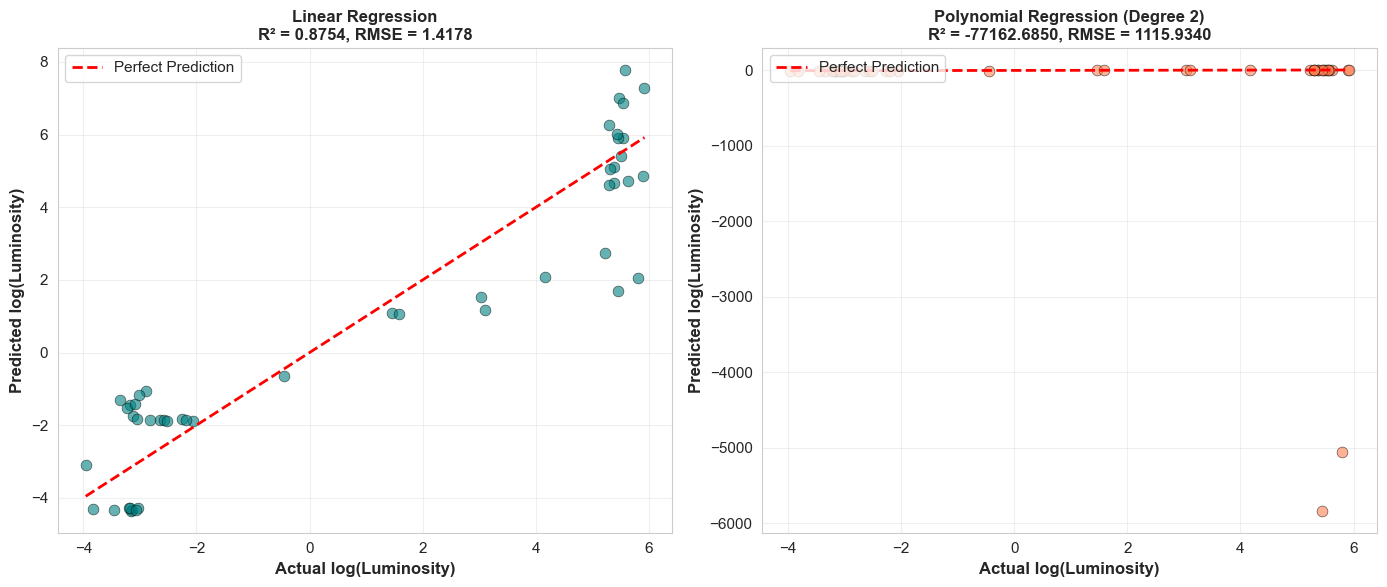

 Plot saved: plots/predicted_vs_actual.png


In [98]:
print("\n Creating prediction visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression
axes[0].scatter(y_test, y_test_pred, alpha=0.6, c='teal', s=60, edgecolor='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Luminosity)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted log(Luminosity)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Linear Regression\nR² = {test_r2:.4f}, RMSE = {test_rmse:.4f}', 
                  fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Polynomial Regression
axes[1].scatter(y_test, y_test_poly_pred, alpha=0.6, c='coral', s=60, edgecolor='black', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual log(Luminosity)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted log(Luminosity)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Polynomial Regression (Degree 2)\nR² = {test_poly_r2:.4f}, RMSE = {poly_rmse:.4f}', 
                  fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/predicted_vs_actual.png")

In [99]:
### Residual Analysis


 Creating residual analysis plots...


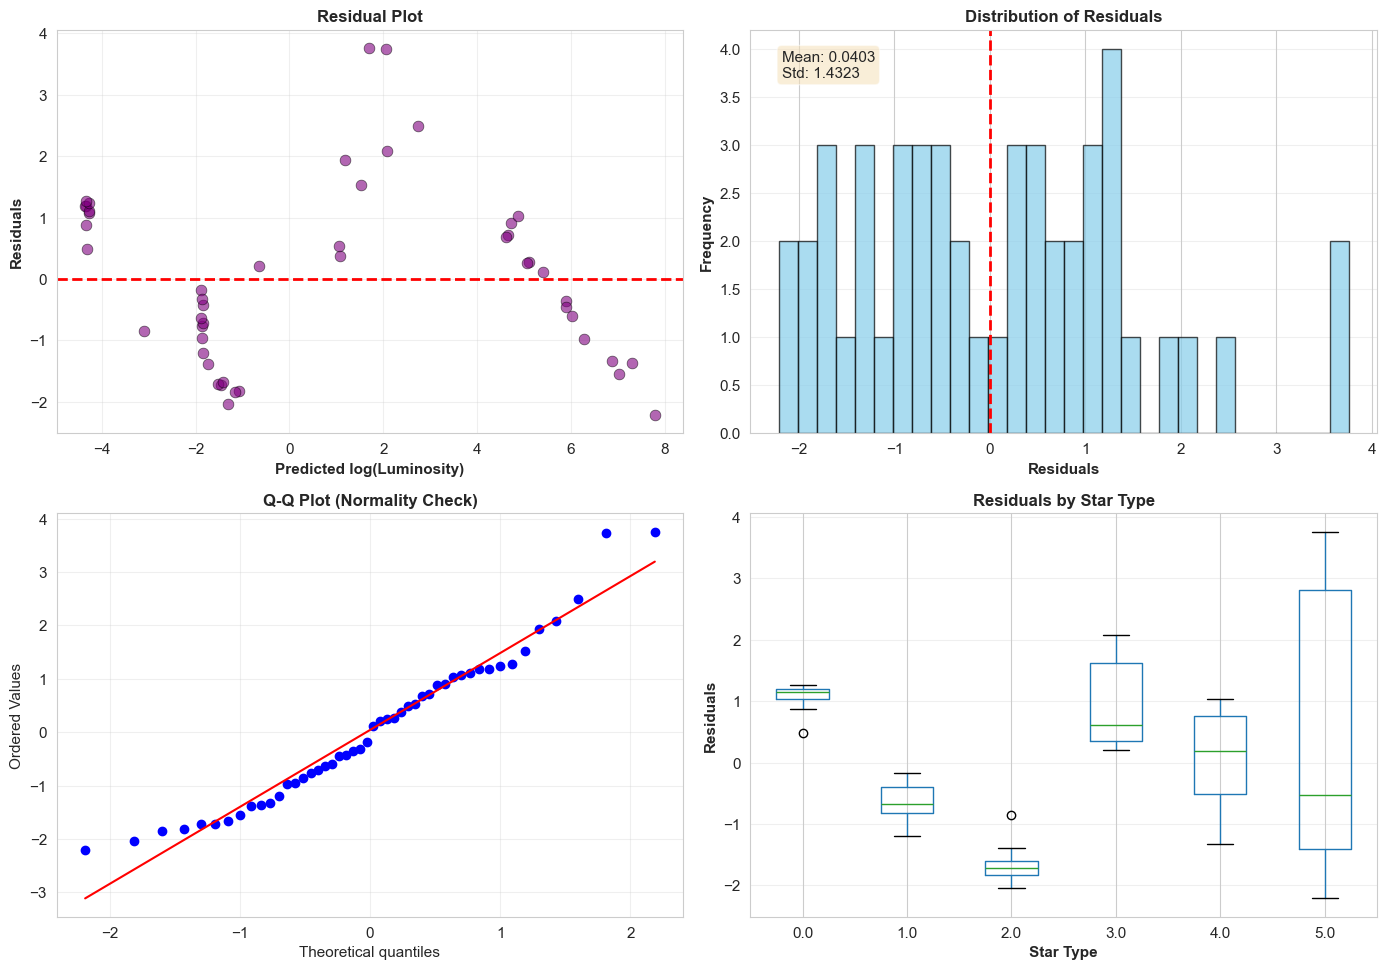

 Plot saved: plots/residual_analysis.png

 Residual Analysis:
   Mean of residuals: 0.040317 (should be ≈ 0)
   Std of residuals: 1.432260
   Min residual: -2.2118
   Max residual: 3.7572

 Normality Test (D'Agostino-Pearson):
   p-value: 0.201543
    Residuals appear normally distributed (p > 0.05)


In [100]:
print("\n Creating residual analysis plots...")

# Calculate residuals
residuals = y_test - y_test_pred

# Create comprehensive residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residual scatter plot
axes[0, 0].scatter(y_test_pred, residuals, alpha=0.6, c='purple', s=60, edgecolor='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted log(Luminosity)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add statistics
mean_res = residuals.mean()
std_res = residuals.std()
axes[0, 1].text(0.05, 0.95, f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}',
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Q-Q Plot for normality check
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals by Star Type
star_types_test = X_test_raw['Star type'].values
residuals_df = pd.DataFrame({
    'Star Type': star_types_test,
    'Residuals': residuals
})

residuals_df.boxplot(column='Residuals', by='Star Type', ax=axes[1, 1])
axes[1, 1].set_title('Residuals by Star Type', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Star Type', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[1, 1].get_figure().suptitle('')  # Remove automatic title
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('plots/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Plot saved: plots/residual_analysis.png")

# Interpret residuals
print("\n Residual Analysis:")
print(f"   Mean of residuals: {residuals.mean():.6f} (should be ≈ 0)")
print(f"   Std of residuals: {residuals.std():.6f}")
print(f"   Min residual: {residuals.min():.4f}")
print(f"   Max residual: {residuals.max():.4f}")

# Normality test
_, p_value = stats.normaltest(residuals)
print(f"\n Normality Test (D'Agostino-Pearson):")
print(f"   p-value: {p_value:.6f}")
if p_value > 0.05:
    print(f"    Residuals appear normally distributed (p > 0.05)")
else:
    print(f"    Residuals may not be normally distributed (p < 0.05)")


In [101]:
### Predictions by Star Type


PERFORMANCE BY STAR TYPE

 Star Type 0.0 (8 samples):
   R² Score: -18.5845
   RMSE:     1.0824
   Mean Error: 1.0543

 Star Type 1.0 (8 samples):
   R² Score: -4.3896
   RMSE:     0.7244
   Mean Error: -0.6515

 Star Type 2.0 (8 samples):
   R² Score: -28.8402
   RMSE:     1.6674
   Mean Error: -1.6323

 Star Type 3.0 (8 samples):
   R² Score: 0.5969
   RMSE:     1.1922
   Mean Error: 0.9487

 Star Type 4.0 (8 samples):
   R² Score: -20.9372
   RMSE:     0.8156
   Mean Error: 0.0465

 Star Type 5.0 (8 samples):
   R² Score: -127.8404
   RMSE:     2.3449
   Mean Error: 0.4763


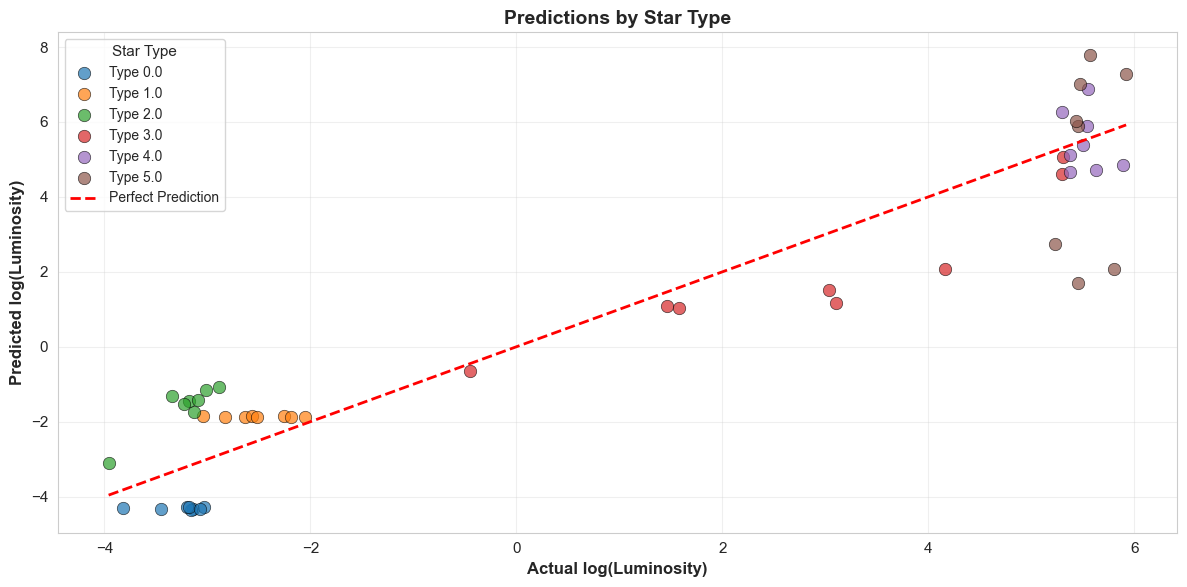


 Plot saved: plots/predictions_by_star_type.png


In [102]:
# Create predictions dataframe with star types
predictions_by_type = pd.DataFrame({
    'Star Type': X_test_raw['Star type'].values,
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Error': y_test.values - y_test_pred
})

# Calculate metrics by star type
print("\n" + "="*100)
print("PERFORMANCE BY STAR TYPE")
print("="*100)

for star_type in sorted(predictions_by_type['Star Type'].unique()):
    subset = predictions_by_type[predictions_by_type['Star Type'] == star_type]
    r2 = r2_score(subset['Actual'], subset['Predicted'])
    rmse = np.sqrt(mean_squared_error(subset['Actual'], subset['Predicted']))
    count = len(subset)
    
    print(f"\n Star Type {star_type} ({count} samples):")
    print(f"   R² Score: {r2:.4f}")
    print(f"   RMSE:     {rmse:.4f}")
    print(f"   Mean Error: {subset['Error'].mean():.4f}")

# Visualize predictions by star type
fig, ax = plt.subplots(figsize=(12, 6))

for star_type in sorted(predictions_by_type['Star Type'].unique()):
    subset = predictions_by_type[predictions_by_type['Star Type'] == star_type]
    ax.scatter(subset['Actual'], subset['Predicted'], 
               label=f'Type {star_type}', alpha=0.7, s=80, edgecolor='black', linewidth=0.5)

ax.plot([predictions_by_type['Actual'].min(), predictions_by_type['Actual'].max()],
        [predictions_by_type['Actual'].min(), predictions_by_type['Actual'].max()],
        'r--', lw=2, label='Perfect Prediction')

ax.set_xlabel('Actual log(Luminosity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted log(Luminosity)', fontsize=12, fontweight='bold')
ax.set_title('Predictions by Star Type', fontsize=14, fontweight='bold')
ax.legend(title='Star Type', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/predictions_by_star_type.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Plot saved: plots/predictions_by_star_type.png")

In [103]:
### Save Predictions

In [104]:
print("\n Saving predictions to CSV...")

# Create comprehensive predictions dataframe
predictions_df = pd.DataFrame({
    'Star Type': X_test_raw['Star type'].values,
    'Spectral Class': X_test_raw['Spectral Class'].values,
    'Temperature(K)': X_test_raw['Temperature(K)'].values,
    'Radius(R/Ro)': X_test_raw['Radius(R/Ro)'].values,
    'Actual_log_Luminosity': y_test.values,
    'Actual_Luminosity': 10 ** y_test.values,
    'Predicted_log_Luminosity_Linear': y_test_pred,
    'Predicted_Luminosity_Linear': 10 ** y_test_pred,
    'Predicted_log_Luminosity_Poly': y_test_poly_pred,
    'Predicted_Luminosity_Poly': 10 ** y_test_poly_pred,
    'Residual_Linear': y_test.values - y_test_pred,
    'Residual_Poly': y_test.values - y_test_poly_pred,
    'Percent_Error_Linear': ((10**y_test.values - 10**y_test_pred) / 10**y_test.values * 100),
    'Percent_Error_Poly': ((10**y_test.values - 10**y_test_poly_pred) / 10**y_test.values * 100)
})

# Save to CSV
predictions_df.to_csv('results/predictions.csv', index=False)
print(f" Predictions saved to: results/predictions.csv")
print(f" Saved {len(predictions_df)} predictions")

# Display sample predictions
print("\n Sample Predictions:")
print(predictions_df.head(10).to_string(index=False))



 Saving predictions to CSV...
 Predictions saved to: results/predictions.csv
 Saved 48 predictions

 Sample Predictions:
 Star Type Spectral Class  Temperature(K)  Radius(R/Ro)  Actual_log_Luminosity  Actual_Luminosity  Predicted_log_Luminosity_Linear  Predicted_Luminosity_Linear  Predicted_log_Luminosity_Poly  Predicted_Luminosity_Poly  Residual_Linear  Residual_Poly  Percent_Error_Linear  Percent_Error_Poly
       1.0              M          3243.0         0.730              -2.638272            0.00230                        -1.871590                     0.013440                      -2.409006                   0.003899        -0.766682      -0.229266           -484.361833          -69.537514
       3.0              A         14060.0         5.745               3.038223         1092.00000                         1.515511                    32.772644                       3.498587                3152.005724         1.522711      -0.460364             96.998842         -188.645213
  

In [105]:
### Save Model Summery

In [106]:
# Create summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['R² Score', 'RMSE', 'MAE', 'Mean CV R²', 'Std CV R²', 'Train/Test Split', 'Random State'],
    'Linear Regression': [
        f'{test_r2:.6f}',
        f'{test_rmse:.6f}',
        f'{test_mae:.6f}',
        f'{cv_scores.mean():.6f}',
        f'{cv_scores.std():.6f}',
        f'{CONFIG["test_size"]*100:.0f}% test',
        str(CONFIG['random_state'])
    ],
    'Polynomial Regression': [
        f'{test_poly_r2:.6f}',
        f'{poly_rmse:.6f}',
        f'{poly_mae:.6f}',
        'N/A',
        'N/A',
        f'{CONFIG["test_size"]*100:.0f}% test',
        str(CONFIG['random_state'])
    ]
})

summary_stats.to_csv('results/model_summary.csv', index=False)
print(f" Model summary saved to: results/model_summary.csv")
print("\n" + summary_stats.to_string(index=False))

 Model summary saved to: results/model_summary.csv

          Metric Linear Regression Polynomial Regression
        R² Score          0.875437         -77162.684974
            RMSE          1.417835           1115.934017
             MAE          1.169474            227.691587
      Mean CV R²          0.891214                   N/A
       Std CV R²          0.018055                   N/A
Train/Test Split          20% test              20% test
    Random State                42                    42


In [107]:
### Making new Predictions

In [108]:
# Create a new star observation
new_star = pd.DataFrame({
    'Temperature(K)': [6000],
    'Radius(R/Ro)': [1.0],
    'Star type': [3],
    'Spectral Class': ['G']
})

# Preprocess the new data
new_star_processed = preprocessor.transform(new_star)

# Make prediction
predicted_log_lum = lr.predict(new_star_processed)[0]
predicted_luminosity = 10 ** predicted_log_lum

print(f"Predicted log(Luminosity): {predicted_log_lum:.4f}")
print(f"Predicted Luminosity: {predicted_luminosity:.4f} L☉")

Predicted log(Luminosity): 2.7355
Predicted Luminosity: 543.8682 L☉
